In [1]:
from network import Actor
from network import Critic
import torch
import numpy as np
import torch.optim as optim
from collections import deque,namedtuple
import random
import copy
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
%matplotlib inline


/home/brabeem/anaconda3/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
##class to define the replay_buffer##
class replay_buffer():
    def __init__(self,buffer_size):
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("experience",["state","action","reward","next_state","done"])

    def add(self,state,action,reward,next_state,done):
        e  = self.experience(state,action,reward,next_state,done)
        #print(e.state.shape)
        self.memory.append(e)

    def sample(self,batch_size):
        expereinces = random.sample(self.memory,batch_size)
        actions = torch.from_numpy(np.vstack([e.action for e in expereinces if e is not None])).float()
        states = torch.from_numpy(np.vstack([e.state for e in expereinces if e is not None])).float()
        #print("states shape:",states.shape)
        rewards = torch.from_numpy(np.vstack([e.reward for e in expereinces if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in expereinces if e is not None])).float()
        #print("next_states:",next_states.shape)
        dones = torch.from_numpy(np.vstack([e.done for e in expereinces if e is not None]).astype(np.uint8)).float()
        return (states,actions,rewards,next_states,dones)        
    def __len__(self):
        return len(self.memory)

##class to define the noise for exploration##
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


In [8]:
##class to define the agent##
class ddpg():
    ##initialize the requirements##
    def __init__(self,env):
        ##Create and initialize the actor and critic networks##
        self.env  = env
        self.local_actor = Actor(env.observation_space.shape[0],env.action_space.shape[0])
        self.target_actor = Actor(env.observation_space.shape[0],env.action_space.shape[0])
        self.local_critic = Critic(env.observation_space.shape[0],env.action_space.shape[0])
        self.target_critic = Critic(env.observation_space.shape[0],env.action_space.shape[0])
        ##initialize some hyperparameters##
        self._init_hyperparameters()
        ##define optimizers for actor and critic network##
        self.actor_optimizer = optim.Adam(self.local_actor.parameters(),lr=self.LR,weight_decay=self.weight_decay)
        self.critic_optimizer = optim.Adam(self.local_critic.parameters(),lr=self.LR,weight_decay=self.weight_decay)
        ##make the parameters of actor and critic same##
        self.target_actor.load_state_dict(self.local_actor.state_dict())
        self.target_critic.load_state_dict(self.local_critic.state_dict())
        ##initialize memory##
        self.memory = replay_buffer(self.buffer_size)
        ##initialize noise##
        self.seed = random.seed(1)
        self.noise = OUNoise(env.action_space.shape[0],self.seed,self.mu,self.theta,self.sigma)
   
    ##initialize the hyperparmeters##
    def _init_hyperparameters(self):
        self.gamma = 0.999
        self.LR = 1e3
        self.num_episodes = 50
        self.buffer_size = 1000000
        self.batch_size = 128  
        self.mu = 0
        self.theta = 0.15
        self.sigma = 0.2
        self.max_tstep_per_eps = 200
        self.tau = 1e-2
        self.weight_decay = 0.0001
   

    ##define how to get a action with or without noise,return numpy array##
    def get_action(self,state,with_noise=True):
        ##do normally ## at last add noise if with_noise is True##
        self.local_actor.eval()
        with torch.no_grad():
            action = np.array(self.local_actor(state))
        self.local_actor.train()
        if with_noise:
            noise = self.noise.sample()
            action = action + noise
        return np.clip(action,-1,1) 
   
    
    ##update the network parameters according to a sampeld batch##
    def update(self):
        states,actions,rewards,next_states,dones = self.memory.sample(self.batch_size)
        #print(states.shape)
        ##updating critic network##
        Q_target = self.target_critic(next_states,self.target_actor(next_states).detach()).detach()
        Q_target = rewards + self.gamma * Q_target* (1-dones)
        Q_expected = self.local_critic(states,actions)
        critic_loss = nn.MSELoss()(Q_target,Q_expected)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        ##updating actor network##
        #print(states.shape)
        Q_loss = -self.local_critic(states,self.local_actor(states)).mean()
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        Q_loss.backward()
        self.actor_optimizer.step()

        ##soft update the target networks##
        self.soft_update(self.local_actor,self.target_actor)
        self.soft_update(self.local_critic,self.target_critic)
   
    ##soft updates the target network from the infos of local_networks##
    def soft_update(self,local_net,target_net):
        for local,target in zip(local_net.parameters(),target_net.parameters()):
            target.data.copy_(local.data * self.tau + target.data *(1-self.tau))
            
    
    ##function that learns##
    def learn(self):
        score_per_eps = deque([],10)
        score_across_all_eps = []
        for i_eps in range(1,self.num_episodes+1):
            state = self.env.reset()
            #print(state.shape)
            score = 0
            for t_step in range(self.max_tstep_per_eps):
                action = self.get_action(torch.tensor(state))
                next_state,reward,done,_= self.env.step(action)
                #print(next_state.shape)
                self.memory.add(state,action,reward,next_state,done)
                state = next_state
                score += reward
                ##now,update the actor and critic networks##
                if len(self.memory)>self.batch_size:
                    self.update()
                if done is True:
                    break
            score_per_eps.append(score)
            score_across_all_eps.append(score)
            print("\r","In episode:{}/{} With average of {}".format(i_eps,self.num_episodes,np.mean(score_per_eps)),end="")
        plt.plot(np.arange(len(score_across_all_eps)),np.array(score_across_all_eps))


 In episode:50/50 With average of -1186.9597635873556

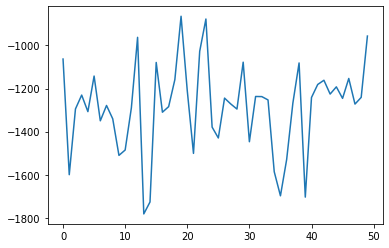

In [9]:
env = gym.make("Pendulum-v1")
agent = ddpg(env)
agent.learn()